# 2D MoM for Rectangular Plate Using Q0 Elements 

## Import Packages

In [1]:
using ForwardDiff
using QuadGK
using HCubature 
using StaticArrays 
using LinearAlgebra 
using BenchmarkTools
using Plots

In [2]:
# a point in 3D is a tuple of 3 coordinates 
# we here introduce static vectors that appear to be vital to reduce the number of allocations 
const Point3D = SVector{3,Float64};

## Section 1: Introduction 

The <b>goal</b> here is to arrive a small proof-of-concept MoM using AD and quadrature for the 2D rectangular plate geometry. We use Q0 elements to represent the magnitization vector (constant over the element). We compute the three components of the magnetic vector potential in the midpoints of the four faces of the cell (destination points). To compute the vector potential at a particular destination, we loop over the elements (quadrilaterals) of the mesh.  

<b>To do</b>
1. seperate single input M into two inputs Mx and My;   
2. Compute $B_y$ ($B_x$) in cell center by $x$-derivative ($y$-derivative) of $A_z$. Use fact that $A_z$ is stored in the yFaces to compute the x-derivative of $A_z$. By = (yFaceAz[1:end-1,:] - yFaceAz[2:end,:])/dx resulting in a matrix of size $nx-by-ny$. Similary, Bx = (xFaceAz[:,1:end-1] - xFaceAz[:,2:end])/dy; 
3. loop over the cell centers and set $(B_x,B_y,0)$ in all centers;[B[k] = [Bx[k],By[k],0]] for k = 1 : nelem;  
4. compute the derivative of $(B_x,B_y,0)$ with respect to $(M_x,M_y,0)$;   

<b>Remarks</b>
1. We integrate the singular kernel in <b>three (3)</b> spatial dimensions. This renders the singularity of the kernel easier to handle. The disavantagof this approach is that the kernel of the vector potential has three non-zeros components. Indeed, while the magnetization vector has a zero z-component (in plane magnmetization), the position vector from source to destination has three (3) non-zero components;
2. We us the vector potential computed in the vertical (horizontal) faces to compute the x-derivative (y-derivative of the vector potential and thus x-component (y-component) of the magnetic flux;  
3. We employ same integration accuracy for self and non-self elements; 
4. We wish to obtain number of statistics of number of function calls; 

## Section 2: Struct Definition for Element and Mesh 

### Section 1.2: Data Structures for Q0 rectangular elements 

1. uniform mesh consisting of $ne = nx \cdot ny$ 3D hexahedral elements with constant thickness;
2. $mx$: vector of $ne$ elements holding constant value of magnetization in $x$-direction; 
3. $my$: vector of $ne$ elements holding constant value of magnetization in $y$-direction;
4. $m = [mx, my]$: vector formed by concatenation of $mx$ and $my$; 
5. $(i,j)$: tuple coding $i$th-$j$th-element in the mesh for $1 \leq i \leq nx$ and $1 \leq j \leq ny$;
6. $I = nx*(j-1)+i$: linearization of $(i,j)$ tuple to retrieve information from the vector $mx$ and $my$; 

In [3]:
# struct to hold a single mesh element
struct Element
  p1::Point3D                  # middle-lower-front node of the block 
  p2::Point3D                  # right-middle-front node of the block  
  p3::Point3D                  # middle-upper-front node of the block 
  p4::Point3D                  # left-middle-front node of the block    
  i::Int64                     # global index first node
  j::Int64                     # global index second node
  I::Int64                     # global index third node
  xs::Float64                  # left (start) point of the element 
  ys::Float64                  # lower (start) point of the element 
  zs::Float64                  # front (start) point of the element     
  xe::Float64                  # right (end) point of the element 
  ye::Float64                  # top (end) point of the element  
  ze::Float64                  # back (end) point of the element       
end

# struct to hold  midpoints of horizontally (x-direction) oriented faces 
struct xFace 
    p1::Point3D                # midpoint of face  
end 

# struct to hold  midpoints of vertically (y-direction) oriented faces
struct yFace 
    p1::Point3D                # midpoint of face  
end 

# struct to hold entire mesh
struct Mesh
  nx::Int64                    # number of elements in the x-direction 
  ny::Int64                    # number of elements in the y-direction
  ne::Int64                    # total number of elements
  Elements::Array{Element,2}   # two-dimensional array of type Element 
  xFaces::Array{xFace,2}       # two-dimensional array of type xFace 
  yFaces::Array{yFace,2}       # two-dimensional array of type yFace     
end

In [4]:
#..sets the mesh with nx * ny elements 
function generate_mesh(nx,ny)
    
    #..set mesh spacings 
    hx = 2/nx; hy = 2/ny;  
    
    #..set thickness ion the z-direction
    thickness = 0.1
    
    #..initialized array of nx-by-ny of type Element  
    Elements = Array{Element}(undef,nx,ny)

    #..set Elements by loop over elements in the mesh.. 
    for i=1:nx 
        xs = -1+(i-1)*hx; xe = xs+hx 
        for j=1:ny 
            ys = -1+(j-1)*hy; ye = ys+hy
            I  = nx*(j-1)+i 
            p1 = Point3D(xs+hx/2,ys,0)
            p2 = Point3D(xe,ys+hy/2,0)
            p3 = Point3D(xs+hx/2,ys,0)
            p4 = Point3D(xs,ys+hy/2,0)
            Elements[i,j] = Element(p1,p2,p3,p4,i,j,I,xs,ys,0,xe,ye,thickness)
        end 
    end
    
    #..initialized array of nx-by-(ny+1) of type xFace   
    xFaces = Array{xFace}(undef,nx,ny+1)

    #..set xFaces by loop over horizontal faces in the mesh.. 
    for i=1:nx 
        xs = -1+(i-1)*hx
        for j=1:ny+1
            ys = -1+(j-1)*hy
            p1 = Point3D(xs+hx/2,ys,0)
            xFaces[i,j] = xFace(p1)
        end 
    end
    
    #..initialized array of (nx+1)-by-ny of type yFace   
    yFaces = Array{yFace}(undef,nx+1,ny)

    #..set xFaces by loop over horizontal faces in the mesh.. 
    for i=1:nx+1
        xs = -1+(i-1)*hx
        for j=1:ny
            ys = -1+(j-1)*hy
            p1 = Point3D(xs,ys+hy/2,0)
            yFaces[i,j] = yFace(p1)
        end 
    end    

    #..set DOF per element
    ne = nx*ny  
    
    #..Store data inside mesh struct  
    mesh = Mesh(nx,ny,ne,Elements,xFaces,yFaces) 

    return mesh 
end 

mesh = generate_mesh(2,2)
element = mesh.Elements[2,2]
xface = mesh.xFaces[2,2]

xFace([0.5, 0.0, 0.0])

## Section 3: Generate 2D Uniform Mesh 

In [5]:
# input for sample call 
nx=10; ny=10;
mesh = generate_mesh(nx,ny);

## Section 4: Set 2D Magnetization Array of 3D-Vectors on Mesh

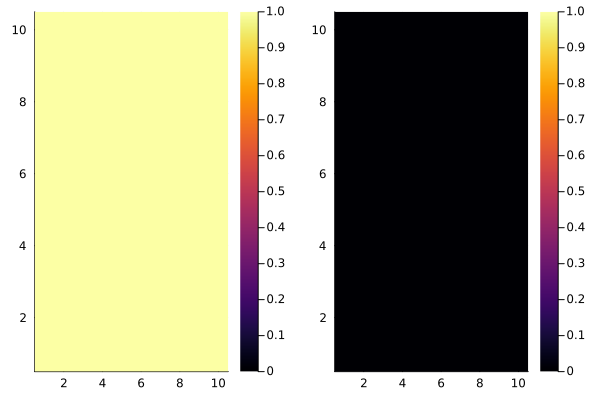

In [6]:
# set the magnetization on each element in the mesh
function set_magnization(element)
    mx = 1.0; my = 0. 
    return SVector{3,Float64}(mx,my,0)
end 

# the results is a 2D array of 3D-vectors 
M = map(element -> set_magnization(element), mesh.Elements)

# postprocessing 
Mx = map(v->v.x, M)
My = map(v->v.y, M)

p1 = heatmap(Mx) 
p2 = heatmap(My)
plot(p1,p2)

In [7]:
M

10×10 Matrix{SVector{3, Float64}}:
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]  …  [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]  …  [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]     [1.0, 0.0, 0.0]  [1.0, 0.0, 0.0]

In [8]:
# set the magnetization on each element in the mesh
function set_magnization(element)
    mx = 1.0; my = 0. 
    return SVector{3,Float64}(mx,my,0)
end 

#..sets vp_kernel on single source element
function vp_kernel(r,rp,elementp,Mp) 
    num = cross(Mp, (r - rp))
    denom = norm(r - rp)^3
    result = num/denom
    return result   
end 

#..sets vp contribution on source element by cubature of vp_density 
function vp_source(face,elementp,mesh,Mx,My)
    r  = face.p1
    (; p1, i, j, I, xs, ys, zs, xe, ye, ze) = elementp 
    xm = (xs+xe)/2; ym = (ys+ye)/2 
    # Mp = SVector{3,Float64}(Mx[i,j],My[i,j],0) 
    Mp = [Mx[i,j],My[i,j],0]
    vp_src = hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xs,ys,zs), (xm,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xs,ym,zs), (xm,ye,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xm,ys,zs), (xe,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xm,ym,zs), (xe,ye,ze))[1]
end

#..set vp on destination element by mapreduce over all source elements  
function vp_destination(face,mesh,M) 
    vp_dest = mapreduce(elementp->vp_source(face,elementp,mesh,M),+,mesh.Elements)
end

#..set vp on mesh by map over all destination elements in the mesh 
function vp_xFaces(mesh,M)
    vpx = map(xface->vp_destination(xface,mesh,M),mesh.xFaces)
end 

#..set vp on mesh by map over all destination elements in the mesh 
function vp_yFaces(mesh,M)
    vpy = map(yface->vp_destination(yface,mesh,M),mesh.yFaces)
end

#..compute bx as y-derivative of values stored on xFaces 
function bx_cell(mesh,M)
    dy = 1/mesh.ny 
    vpx = vp_xFaces(mesh,M)
    Az_xFaces = map(v->v.z, vpx) 
    bx = ( Az_xFaces[:,1:end-1] - Az_xFaces[:,2:end] ) / dy 
end 

#..compute by as x-derivative of values stored on yFaces 
function by_cell(mesh,M)
    dx = 1/mesh.nx 
    vpy = vp_yFaces(mesh,M)
    Az_yFaces = map(v->v.z, vpy)    
    by = ( Az_yFaces[1:end-1,:] - Az_yFaces[2:end,:] ) / dx 
end

# combine bx, by and 0 into a matrix of B-vectors 
function vecb(mesh,M)
    bx = bx_cell(mesh,M)
    by = by_cell(mesh,M)
    B = [SVector{3,Float64}(bx[i,j],by[i,j],0) for i in axes(bx,1), j in axes(by,1)]
end

vecb (generic function with 1 method)

## Section 6: Testing Individual Functions 

In [9]:
#..sets vp_kernel on single source element
function vp_kernel(r,rp,elementp,Mp) 
    num = cross(Mp, (r - rp))
    denom = norm(r - rp)^3
    result = num/denom
    return result   
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)

# the results is a 2D array of 3D-vectors 
M = map(element -> set_magnization(element), mesh.Elements)

# sample call
element  = mesh.Elements[1,1]
r = element.p1 
elementp = mesh.Elements[3,2]
Mp = M[3,2]
rp = Point3D((elementp.xs+elementp.xe)/2,(elementp.ys+elementp.ye)/2,elementp.zs) 
vp_kernel(r,rp,elementp,Mp)
#@code_warntype vp_kernel(r,rp,elementp,Mp)

3-element SVector{3, Float64} with indices SOneTo(3):
  0.0
 -0.0
 -0.21599999999999994

In [10]:
# compute jacobian for fixed element 
# Jacobian non-zero only on index of source element (elementp) (as before)
Cp = ForwardDiff.jacobian(Mp -> vp_kernel(r,rp,elementp,Mp), M[1,1])
display(Cp)

3×3 SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  0.0     0.0     0.216
 -0.0    -0.0    -0.288
 -0.216   0.288   0.0

In [11]:
#..sets vp contribution on source element by cubature of vp_density 
function vp_source(face,elementp,mesh,Mx,My)
    r  = face.p1
    (; p1, i, j, I, xs, ys, zs, xe, ye, ze) = elementp 
    xm = (xs+xe)/2; ym = (ys+ye)/2 
    # Mp = SVector{3,Float64}(Mx[i,j],My[i,j],zeros(eltype(Mx[i,j]),1)[1]) 
    Mp = [Mx[i,j],My[i,j],0] 
    vp_src = hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xs,ys,zs), (xm,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xs,ym,zs), (xm,ye,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xm,ys,zs), (xe,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,Mp), (xm,ym,zs), (xe,ye,ze))[1]
end

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)

# the results is a 2D array of 3D-vectors 
M = map(element -> set_magnization(element), mesh.Elements)
Mx = map(v->v.x, M); My = map(v->v.y, M)

# sample call
xface    = mesh.xFaces[1,1]
elementp = mesh.Elements[2,1]
vp_source(xface,elementp,mesh,Mx,My)

3-element Vector{Float64}:
  0.0
  0.007558492070774823
 -0.03799738028353785

In [12]:
Cp = ForwardDiff.jacobian(Mx -> vp_source(xface,elementp,mesh,Mx,My), Mx)  
display(Cp)

3×9 Matrix{Float64}:
 0.0   0.0         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.00755849  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -0.0379974   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [13]:
#..set vp on destination element by mapreduce over all source elements  
function vp_destination(face,mesh,Mx,My) 
    vp_dest = mapreduce(elementp->vp_source(face,elementp,mesh,Mx,My),+,mesh.Elements)
end

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)

# the results is a 2D array of 3D-vectors 
M = map(element -> set_magnization(element), mesh.Elements)
Mx = map(v->v.x, M); My = map(v->v.y, M)

# sample call
xface   = mesh.xFaces[1,1]
vp_dest = vp_destination(xface,mesh,Mx,My)[3]

-0.6487275172500561

In [14]:
# single component version only 
Cp = ForwardDiff.gradient(Mx -> vp_destination(xface,mesh,Mx,My)[3], Mx)

3×3 Matrix{Float64}:
 -0.484985    -0.0464622   -0.0162807
 -0.0379974   -0.026677    -0.0130157
 -0.00581868  -0.00978307  -0.00770825

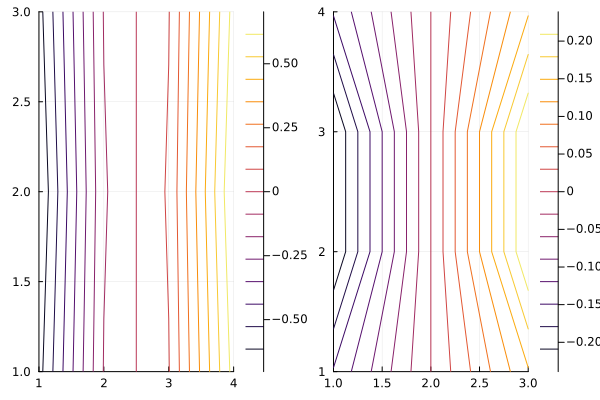

In [29]:
function vp_xFaces(mesh,Mx,My)
    vpx = map(xface->vp_destination(xface,mesh,Mx,My)[3],mesh.xFaces)
end 

#..set vp on mesh by map over all destination elements in the mesh 
function vp_yFaces(mesh,Mx,My)
    vpy = map(yface->vp_destination(yface,mesh,Mx,My)[3],mesh.yFaces)
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)

# the results is a 2D array of 3D-vectors 
M = map(element -> set_magnization(element), mesh.Elements)
Mx = map(v->v.x, M); My = map(v->v.y, M)

# sample call
vpx = vp_xFaces(mesh,Mx,My)
vpy = vp_yFaces(mesh,Mx,My)

# postprocessing 
Az_xFaces = vpx # map(v->v[3], vpx)
Az_yFaces = vpy # map(v->v[3], vpy)

p1 = contour(Az_xFaces) 
p2 = contour(Az_yFaces)
plot(p1,p2)

In [30]:
Cp = ForwardDiff.jacobian(Mx -> vp_xFaces(mesh,Mx,My), Mx)

12×9 Matrix{Float64}:
 -0.484985    -0.0379974  -0.00581868  …  -0.0130157  -0.00770825
 -0.0379974   -0.484985   -0.0379974      -0.0162807  -0.0130157
 -0.00581868  -0.0379974  -0.484985       -0.0130157  -0.0162807
  0.484985     0.0379974   0.00581868     -0.026677   -0.00978307
  0.0379974    0.484985    0.0379974      -0.0464622  -0.026677
  0.00581868   0.0379974   0.484985    …  -0.026677   -0.0464622
  0.0464622    0.026677    0.00978307     -0.0379974  -0.00581868
  0.026677     0.0464622   0.026677       -0.484985   -0.0379974
  0.00978307   0.026677    0.0464622      -0.0379974  -0.484985
  0.0162807    0.0130157   0.00770825      0.0379974   0.00581868
  0.0130157    0.0162807   0.0130157   …   0.484985    0.0379974
  0.00770825   0.0130157   0.0162807       0.0379974   0.484985

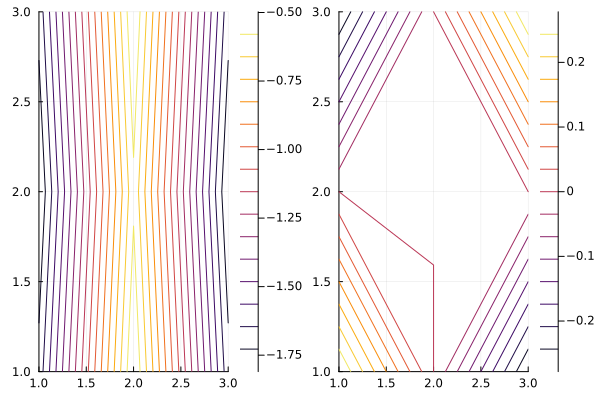

In [32]:
#..compute bx as y-derivative of values stored on xFaces
function bx_cell(mesh,Mx,My)
    dy = 1/mesh.ny 
    vpx = vp_xFaces(mesh,Mx,My)
    Az_xFaces = vpx # map(v->v.z, vpx) 
    bx = ( Az_xFaces[:,1:end-1] - Az_xFaces[:,2:end] ) / dy 
end 

#..compute by as x-derivative of values stored on yFaces 
function by_cell(mesh,Mx,My)
    dx = 1/mesh.nx 
    vpy = vp_yFaces(mesh,Mx,My)
    Az_yFaces = vpy # map(v->v.z, vpy)    
    by = ( Az_yFaces[1:end-1,:] - Az_yFaces[2:end,:] ) / dx 
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)

# the results is a 2D array of 3D-vectors 
M = map(element -> set_magnization(element), mesh.Elements)
Mx = map(v->v.x, M); My = map(v->v.y, M)

# sample call 
bx = bx_cell(mesh,Mx,My) 
by = by_cell(mesh,Mx,My)

p1 = contour(bx) 
p2 = contour(by)
plot(p1,p2)

In [35]:
Cxx = ForwardDiff.jacobian(Mx -> bx_cell(mesh,Mx,My), Mx)
Cxy = ForwardDiff.jacobian(My -> bx_cell(mesh,Mx,My), My)

9×9 Matrix{Float64}:
 -1.19696e-15   0.0          -1.04083e-17  …  -0.037479     -0.0206793
 -4.16334e-17  -1.85789e-15   4.16334e-17      1.78893e-18  -0.037479
 -1.04083e-17   0.0          -1.01481e-15      0.037479     -7.96889e-18
  1.57686e-15   0.188847      0.03115         -0.188847     -0.03115
 -0.188847      2.498e-16     0.188847         1.20021e-15  -0.188847
 -0.03115      -0.188847      1.4923e-15   …   0.188847     -6.30355e-16
  3.57787e-18   0.037479      0.0206793        4.16334e-17   2.08167e-17
 -0.037479     -3.25261e-19   0.037479        -8.69096e-16  -4.16334e-17
 -0.0206793    -0.037479      4.87891e-18     -4.16334e-17   2.23779e-16

In [36]:
Cyx = ForwardDiff.jacobian(Mx -> by_cell(mesh,Mx,My), Mx)
Cyy = ForwardDiff.jacobian(My -> by_cell(mesh,Mx,My), My)

9×9 Matrix{Float64}:
  2.90991     -1.31557    -0.0905444    0.227984   …   0.0118932  -0.00622444
 -1.31557      2.90991    -1.31557     -0.033961       0.0349121   0.0118932
 -0.0905444   -1.31557     2.90991     -0.0409841      0.0118932   0.0349121
  0.227984    -0.033961   -0.0409841    2.90991       -0.033961   -0.0409841
 -0.033961     0.227984   -0.033961    -1.31557        0.227984   -0.033961
 -0.0409841   -0.033961    0.227984    -0.0905444  …  -0.033961    0.227984
  0.0349121    0.0118932  -0.00622444   0.227984      -1.31557    -0.0905444
  0.0118932    0.0349121   0.0118932   -0.033961       2.90991    -1.31557
 -0.00622444   0.0118932   0.0349121   -0.0409841     -1.31557     2.90991

## Section 7: Apply to 2D Thin Plate 

In [ ]:
# input for sample call 
nx=30; ny=30;
mesh = generate_mesh(nx,ny);

M_array = map(element -> set_magnization(element), mesh.Elements)

mx = vec(map(v->v.x, M_array)); my = vec(map(v->v.y, M_array));  M = [mx;my]

vpx = vp_xFaces(mesh,M)
vpy = vp_yFaces(mesh,M)

# postprocessing 
Az_xFaces = map(v->v.z, vpx)
Az_yFaces = map(v->v.z, vpy)

p1 = contour(Az_xFaces) 
p2 = contour(Az_yFaces)
plot(p1,p2)

## Section 8: More   

In [20]:
function foo(x)
    mapreduce(v->v,+,x)
end 

foo (generic function with 1 method)

In [25]:
x0 = [1;2]

2-element Vector{Int64}:
 1
 2

In [26]:
foo(x0)

3

In [28]:
ForwardDiff.gradient(x->foo(x),x0)

2-element Vector{Int64}:
 1
 1